# Simulated data
In this script, we generate 2-cluster synthetic 1d data, and test our model on it.

First, we generate data and save it to a file named `../data/test.jld2`.

In [6]:
include("generator.jl")

Next, load the data and run the MCMC according to some simulation settings. These configurations are written in `test2.TOML`; the simulation results are setup.

`test.TOML` has the following settings:
(TODO: fill this in; test2.TOML is just a slightly modified version of test.TOML)

In [2]:
config_file = "test2.TOML"
include("MCMC.jl")
MCMC(config_file)

0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
1.0%┣▍                                         ┫ 1/100 [00:07<Inf:Inf, InfGs/it]
2.0%┣█                                              ┫ 2/100 [00:07<11:39, 7s/it]
7.0%┣███▎                                           ┫ 7/100 [00:07<01:52, 1s/it]
13.0%┣█████▉                                       ┫ 13/100 [00:07<00:53, 2it/s]
18.0%┣████████                                     ┫ 18/100 [00:07<00:35, 2it/s]
23.0%┣██████████▍                                  ┫ 23/100 [00:07<00:26, 3it/s]
27.0%┣████████████▏                                ┫ 27/100 [00:07<00:21, 3it/s]
33.0%┣██████████████▉                              ┫ 33/100 [00:08<00:16, 4it/s]
38.0%┣█████████████████                            ┫ 38/100 [00:08<00:13, 5it/s]
44.0%┣███████████████████▉                         ┫ 44/100 [00:08<00:10, 6it/s]
48.0%┣█████████████████████▋                       ┫ 48/100 [00:08<00:08, 6it/s]
54.0%┣██████████████████████

In [8]:
using RCall 
fitdata = load("fit_test.jld2");
simdata = load("test.jld2");
y_orig = simdata["y"];
y_imputed = simdata["x"];

We plot the censored data (the first plot) and the imputed data (the green points).

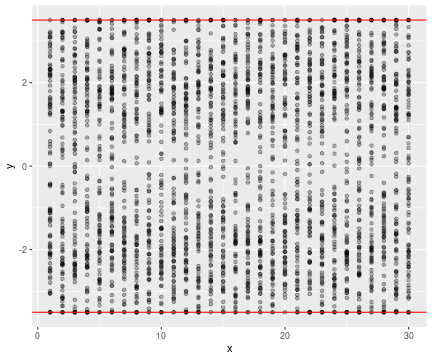

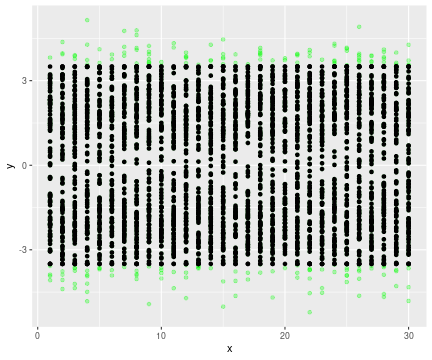

RObject{VecSxp}


In [16]:
@rput y_orig
@rput y_imputed
R"""
library(tidyverse)
TT = 30

## Plot original data
x = lapply(1:TT, function(tt) rep(tt,100)) %>% do.call("c",.)
y = do.call("c", y_orig)
dt = tibble(x=x, y=y)
g = ggplot(dt) + geom_point(aes(x=x, y=y), alpha = .3) +
    geom_hline(yintercept = c(-3.5, 3.5), col = 'red')
plot(g)

## Plot imputed data
x = lapply(1:TT, function(tt) rep(tt,100)) %>% do.call("c",.)
y = do.call("c", y_imputed)
dt_imputed = tibble(x=x, y=y)
g2 = ggplot(dt_imputed) + geom_point(aes(x=x, y=y), col = 'green', alpha = .3) + geom_point(aes(x=x, y=y), alpha = 1, data = dt)
"""

We can visualize the imputation; the red (jittered) censored datapoints have been imputed to create the green points. Neat! 

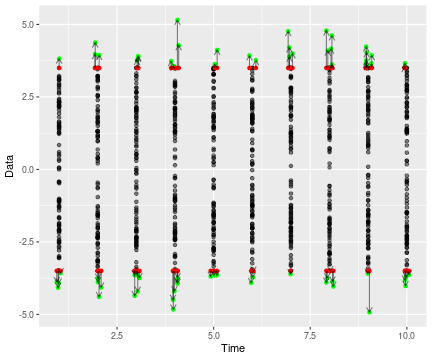

RObject{VecSxp}


In [5]:
@rput y_orig
@rput y_imputed
R"""
library(tidyverse)
TT = 30
trunc_limits = c(-3.5,3.5)
trunc_index = lapply(y_orig, function(one_y_orig){ which(one_y_orig %in% trunc_limits) })
dt = lapply(1:TT, function(tt){
  ind = trunc_index[[tt]]
  tibble(x = tt + runif(length(ind), -0.1, +0.1),  ## jittering the x's for visualization
         orig = y_orig[[tt]][ind], 
         imputed = y_imputed[[tt]][ind])
}) %>% bind_rows()

dt %>% subset(x <= 10) %>% ggplot() + 
geom_point(aes(x=x, y=orig), col = 'red') + 
geom_point(aes(x=x, y=imputed)) +
geom_segment(aes(x = x, y = orig, xend = x, yend = imputed),
                  arrow = arrow(length = unit(0.2, "cm")), alpha = .5) +
ylab("Data") +
xlab("Time") 


dt = lapply(1:TT, function(tt){
  y = y_orig[[tt]]
  y_imputed = y_imputed[[tt]]
  truncated = (y %in% trunc_limits)
  tibble(x = tt,
         xjitter = tt + runif(length(y), -0.1, +0.1),  ## jittering the x's for visualization
         orig = y, 
         imputed = y_imputed,
         truncated = truncated,
         )
}) %>% bind_rows()


dt %>% subset(x <= 10) %>% ggplot() + 
geom_point(aes(x=x, y=orig), alpha = .5) +
geom_point(aes(x=xjitter, y=imputed), col = 'green', data = .%>% subset(truncated == 1)) +
geom_point(aes(x=xjitter, y=orig), data = . %>% subset(truncated==1), col = 'red') +
geom_segment(aes(x = xjitter, y = orig, xend = xjitter, yend = imputed),
                  arrow = arrow(length = unit(0.2, "cm")), alpha = .5, 
                  data = . %>% subset(truncated == 1)
             ) +
ylab("Data") +
xlab("Time") 
"""

Next, we make a plot with the following features (TODO: actually do this)
- Cluster means ($\{\mu_{kt}, t=1,\cdots, T\}, k=1,2$) over time,
- 95% probability regions (bands) for each cluster using,
- Cluster means' thickness are proportional to the cluster probabilities ($\{\pi_{kt}, t=1,\cdots, T\}, k=1,2$).

Next, we plot the true cluster probabilities against the estimated ones.

Next, we plot the imputed data.

We shorten the distance between the two cluster means (TODO: one setup is for when the cluster means touch but don't cross; another setup is for when cluster means actually cross).

We also compare it against several other competing methods. The main competitor is a 2-cluster Gaussian mixture model applied to each timepoint separately. At each time point, the cluster with the higher mean $\mu_{kt}$ is called cluster 2, and the other one is cluster 1. The analyses are repeated with this model.